# Notebook Information
----------------------
**Created By:**   Steven Bennett, Friedrich Hastedt

This is an example notebook for task 1. The goal of task 1 is to develop a model that is able to perform single-step retrosynthesis prediction. Specifically, the goal of the model is given a target molecule, the model should be able to predict a single reaction step that will produce the target molecule from one or more reagents.
The model will be evaluated in 3 different ways:

1. Top-10 score: The percentage the reactants from the test set appear in the top-10 predictions proposed by the model.
2. Duplicates: The percentage of duplicated reactants in the top-10 predictions proposed by the model. (The actual score is 1 - the percentage of duplicated reactants to maximise the score.)
3. Invalidity: The percentage of invalid predictions in the top-10 predictions proposed by the model.
(The actual score is 1 - the percentage of invalid predictions to maximise the score.)

From these evaluation metrics, we will provide a final score for each model, using a weighted average of the different metrics. The final score will be used to rank each team on the GitHub leaderboard.


## Notebook Contents
----------------------

In this notebook, we will show an example of using a pre-trained model as a starting point to generate the output file for submission to the competition. The notebook will cover the following steps:

1. Loading the pre-trained model, and performing data pre-processing steps
2. Generating predictions on the held-out test set and saving the output file

You are free to experiment with as many different models as you like, and this notebook only serves as an example of how to get started. You are free to use any other models that you like, including using ChatGPT to make prediction, and you are free to use any other data that you like. 
The only requirement is that the test set data is used to generate the output file for the submission.

Before executing the notebook, please ensure that you have installed the correct dependencies. It is highly recommended to create a new Anaconda environment specifically for this task. The dependencies can be installed using the following command:

```conda env create -f conda_env.yml```

The kernel for the notebook can then be instaleld using the following command:
    
```python -m ipykernel install --user --name chem_llm_hackathon --display-name "chem_llm_hackathon"```

This will ensure the kernel is locatable by the Jupyter notebook server.

In [ ]:
# Execute these functions to download the model and data
%wget -O 'USPTO50_model_step_500000.pt' 'https://www.dropbox.com/s/fm0cyzxwmxqy7c5/USPTO50_model_step_500000.pt?dl=0'
%wget -O 'USPTO50USPTO50.train.0.pt' 'https://www.dropbox.com/scl/fi/ssalt02e4ae0uggnqq5bn/USPTO50USPTO50.train.0.pt?rlkey=0t151ep0b2b59gng61dpgkxt9&dl=0'

In [2]:
from example_model import Model
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdChemReactions as Reactions
import json

We have provided a checkpoint file, from the MolecularTransformer paper (https://pubs.acs.org/doi/10.1021/acscentsci.9b00576), which has been trained for half-million epochs. For using this model, we have included some initial code for loading the model and generating predictions. You are free to use this model as initial stating point for an initial set of predictions.

To perform a prediction, call the *.predict()* method on the model. The arguments to the method are as follows: 
1. **source_path**: <br> 
Do not modify this, this is the directory to the test molecules. 
2. **num_predictions / beam_size**: <br> 
beam_size is used by the model to generate more than 1 prediction whereas num_predictions handles the number of predictions returned to the user. Please ensure that those are equal to one another. The scoring will be performed on the first 10 predictions, however feel free to return more than 10 predictions and re-rank them to improve your results.
3. **batch_size**: <br>
The number of examples fed to the model during one gradient update step.

In [6]:
# Load the model
model = Model(
    model_path="Models/USPTO50_model_step_500000.pt", 
    gpu=-1 # Set GPU index to the number of the GPU you want to use. -1 for CPU.
)

Lets evaluate the performance of this model on the validation set using the three evaluation metrics



In [ ]:
# First, perform predictions using the small validation set

results = model.predict(
    source_path='Data/val_input_small.txt',
    num_predictions=10,
    batch_size=10,
    beam_size=10
)

# Create some bad results to test the evaluator

# Lots of invalid SMILES

results_invalid = {
    r: [i[:-2] for i in k] for r, k in results.items() 
}

# Lots of duplicates

results_duplicates = {
    r: [k[0] for i in range(10)] for r, k in results.items()
}

/home/sbennett/miniconda3/envs/Datathon_LLM/lib/python3.6/site-packages/torchtext/data/field.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


PRED AVG SCORE: -0.0003, PRED PPL: 1.0003


In [29]:
from eval import Duplicates, InvalidSMILES, TopK

from rdkit import RDLogger
# Silence RDKit warnings
RDLogger.DisableLog('rdApp.*')

evaluators = [Duplicates(), InvalidSMILES(), TopK(k=10, test_path='Data/val_output_small.txt')]

res_names = ["Duplicate Result", "Invalid Results", "Standard Results"]
# Evaluate the model
print("\n------------------\n")
for i, res in enumerate([results_duplicates, results_invalid, results]):
    print(res_names[i])
    for evaluator in evaluators:
        print(evaluator.__class__.__name__, round(evaluator(res), 2))
    print("\n------------------\n")


------------------

Duplicate Result
Duplicates 0.1
InvalidSMILES 1.0
TopK 0.9

------------------

Invalid Results
Duplicates 0.64
InvalidSMILES 0.15
TopK 0.0

------------------

Standard Results
Duplicates 0.65
InvalidSMILES 0.77
TopK 0.9

------------------



Below, we have provided an example of performing the predictions on the test set

In [30]:
# Perform predictions on the test set using a checkpointed model
# Some pararameters to be changed could be the beam size, which specifies the number of molecules that are decoded form the model.
# This will load the test input file and make 250 prediction using the test file. 
results = model.predict(
    source_path='Data/test_input.txt',
    num_predictions=10,
    batch_size=1,
    beam_size=10
)

# Extracitng the SMILES strings of all the targets - These are the targets to have the model predict the reactants of
with open("Data/test_input.txt", "r") as f:
    targets = f.read().replace(" ", "").split("\n")

/home/sbennett/miniconda3/envs/Datathon_LLM/lib/python3.6/site-packages/torchtext/data/field.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


PRED AVG SCORE: -0.0009, PRED PPL: 1.0009


The results should be a dictionary of the form:
    ```{
        product_smiles: [reactant_smiles_1_prediction, reactant_smiles_2_prediction, ...]
    }
    ```
For each product there should be 10 different predictions in order to calculate the individual metrics, and the file should be saved as a JSON file with the name ```task_1_predictions.json```.
For submission, the target molecules are listed in the `test_input` folder.
The submission file can be created and saved using the code below:


In [18]:
print("The number of test set molecules is:", len(results.keys())) # Ensure this is 250
print("The number of predictions per molecule is:", len(results[list(results.keys())[0]])) # Ensure this is 10
with open("../task_1_predictions.json", 'w') as f:
    json.dump(results, f)

The number of test set molecules is: 250
The number of predictions per molecule is: 10


Visualising the reactants predicted by the model can be done using the code below

In [7]:
# Draw the results
for target, reaction in list(results.items()):
    rxn_smiles = ''
    for reactants in reaction:
        for r in reactants.split('.'):
            rxn_smiles += r
            if r != reactants[-1]:
                rxn_smiles += '.'
        rxn_smiles += '>>' + target
        try: 
            rxn = Reactions.ReactionFromSmarts(rxn_smiles, useSmiles=True)
            break
        except:
            continue

RDKit ERROR: [16:31:56] SMILES Parse Error: syntax error while parsing: COC(=O)N[C@H](C(=O)N1[C@@H]2CC[C@@H](C2)[C@H]1c1nc2ccc(.
RDKit ERROR: [16:31:56] SMILES Parse Error: Failed parsing SMILES 'COC(=O)N[C@H](C(=O)N1[C@@H]2CC[C@@H](C2)[C@H]1c1nc2ccc(.' for input: 'COC(=O)N[C@H](C(=O)N1[C@@H]2CC[C@@H](C2)[C@H]1c1nc2ccc(.'
RDKit ERROR: [16:31:56] SMILES Parse Error: syntax error while parsing: COC(COC(c1ccccc1)(c1ccccc1)c1ccccc1.
RDKit ERROR: [16:31:56] SMILES Parse Error: Failed parsing SMILES 'COC(COC(c1ccccc1)(c1ccccc1)c1ccccc1.' for input: 'COC(COC(c1ccccc1)(c1ccccc1)c1ccccc1.'
RDKit ERROR: [16:31:56] SMILES Parse Error: syntax error while parsing: CC1(C)OB(C2=CCC(O)(C(=O.
RDKit ERROR: [16:31:56] SMILES Parse Error: Failed parsing SMILES 'CC1(C)OB(C2=CCC(O)(C(=O.' for input: 'CC1(C)OB(C2=CCC(O)(C(=O.'


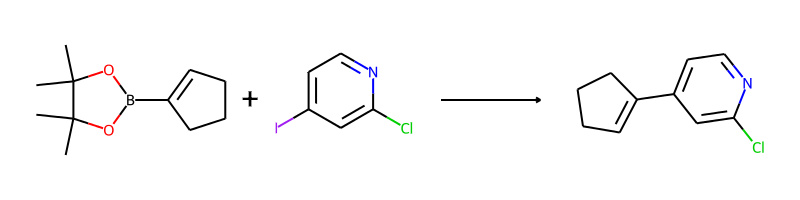

In [8]:
# Print an example reaction that was predicted
Draw.ReactionToImage(rxn)

From this point, you have a model that is able to predict the reactants for a given target molecule reasonably well. There are multiple steps that can be taken from this point to improve the model. Some suggestions are:
1. Training the model for more epochs (see below cell for an example). The training dataset for the model is provided.
2. Using a different model architecture. The MolecularTransformer model is only one of many possible models that can be used for this task. You are free to use any model that you like, including ChatGPT or the OpenAI API interface.
Some recommendations of things to try are: IBM RXN (https://rxn.res.ibm.com), ChemCrow (https://github.com/ur-whitelab/chemcrow-public - uses the OpenAI API credits)


In [11]:
# Run more trianing epochs from the original model
model.train(
    data_path="USPTO50USPTO50",
    num_epochs=500001,
    gpu_ranks="0",
)

['/home/sbennett/Postdoc/Hackathons/Chem_LLM_Hackathon/Task_1/Models/USPTO50_model_step_500000.pt']


[2023-07-18 16:47:38,777 INFO] Loading checkpoint from /home/sbennett/Postdoc/Hackathons/Chem_LLM_Hackathon/Task_1/Models/USPTO50_model_step_500000.pt
[2023-07-18 16:47:39,016 INFO] Loading train dataset from /home/sbennett/Postdoc/Hackathons/Chem_LLM_Hackathon/Fred_Folder/Hackathon/example_notebooks/MolecularTransformer/data/USPTO50USPTO50.train.0.pt, number of examples: 40008
[2023-07-18 16:47:39,017 INFO] Loading vocab from checkpoint at /home/sbennett/Postdoc/Hackathons/Chem_LLM_Hackathon/Task_1/Models/USPTO50_model_step_500000.pt.
[2023-07-18 16:47:39,017 INFO]  * vocabulary size. source = 87; target = 87
[2023-07-18 16:47:39,018 INFO] Building model...
[2023-07-18 16:47:39,322 INFO] NMTModel(
  (encoder): TransformerEncoder(
    (embeddings): Embeddings(
      (make_embedding): Sequential(
        (emb_luts): Elementwise(
          (0): Embedding(87, 256, padding_idx=1)
        )
        (pe): PositionalEncoding(
          (dropout): Dropout(p=0.1, inplace=False)
        )
      

In [ ]:
### *Extra: Further Resources
-----------------------------

For students that find the topic of retrosynthesis and LLMs in chemistry interesting, here are some resources that could you started: 

1. Deep learning in retrosynthesis planning: datasets, models and tools - https://academic.oup.com/bib/article/23/1/bbab391/6375056 (a review article about ML retrosynthesis)
2. A smile is all you need: Predicting limiting activity coefficients from SMILES with natural language processing - https://arxiv.org/abs/2206.07048v1 (how SMILES can be used for QSPR)
3. An introductory course to Transformer and how to use them with the HuggingFace python package - https://huggingface.co/learn/nlp-course/chapter1/1

: 